In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# set random seed for comparing the two result calculations
tf.set_random_seed(1)

# this is data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# hyperparameters
lr = 0.001
training_iters = 100000
batch_size = 128

n_inputs = 28   # MNIST data input (img shape: 28*28)
n_steps = 28    # time steps
n_hidden_units = 128   # neurons in hidden layer
n_classes = 10      # MNIST classes (0-9 digits)

# tf Graph input
x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_classes])

# Define weights
weights = {
    # (28, 128)
    'in': tf.Variable(tf.random_normal([n_inputs, n_hidden_units])),
    # (128, 10)
    'out': tf.Variable(tf.random_normal([n_hidden_units, n_classes]))
}
biases = {
    # (128, )
    'in': tf.Variable(tf.constant(0.1, shape=[n_hidden_units, ])),
    # (10, )
    'out': tf.Variable(tf.constant(0.1, shape=[n_classes, ]))
}


def RNN(X, weights, biases):
    # hidden layer for input to cell
    ########################################

    # transpose the inputs shape from
    # X ==> (128 batch * 28 steps, 28 inputs)
    X = tf.reshape(X, [-1, n_inputs])

    # into hidden
    # X_in = (128 batch * 28 steps, 128 hidden)
    X_in = tf.matmul(X, weights['in']) + biases['in']
    # X_in ==> (128 batch, 28 steps, 128 hidden)
    X_in = tf.reshape(X_in, [-1, n_steps, n_hidden_units])

    # cell
    ##########################################

    # basic LSTM Cell.
    if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
        cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden_units, forget_bias=1.0, state_is_tuple=True)
    else:
        cell = tf.contrib.rnn.BasicLSTMCell(n_hidden_units)
    # lstm cell is divided into two parts (c_state, h_state)
    init_state = cell.zero_state(batch_size, dtype=tf.float32)

    # You have 2 options for following step.
    # 1: tf.nn.rnn(cell, inputs);
    # 2: tf.nn.dynamic_rnn(cell, inputs).
    # If use option 1, you have to modified the shape of X_in, go and check out this:
    # https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/recurrent_network.py
    # In here, we go for option 2.
    # dynamic_rnn receive Tensor (batch, steps, inputs) or (steps, batch, inputs) as X_in.
    # Make sure the time_major is changed accordingly.
    outputs, final_state = tf.nn.dynamic_rnn(cell, X_in, initial_state=init_state, time_major=False)

    # hidden layer for output as the final results
    #############################################
    # results = tf.matmul(final_state[1], weights['out']) + biases['out']

    # # or
    # unpack to list [(batch, outputs)..] * steps
    if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
        outputs = tf.unpack(tf.transpose(outputs, [1, 0, 2]))    # states is the last outputs
    else:
        outputs = tf.unstack(tf.transpose(outputs, [1,0,2]))
    results = tf.matmul(outputs[-1], weights['out']) + biases['out']    # shape = (128, 10)

    return results


pred = RNN(x, weights, biases)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
train_op = tf.train.AdamOptimizer(lr).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

with tf.Session() as sess:
    # tf.initialize_all_variables() no long valid from
    # 2017-03-02 if using tensorflow >= 0.12
    if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
        init = tf.initialize_all_variables()
    else:
        init = tf.global_variables_initializer()
    sess.run(init)
    step = 0
    while step * batch_size < training_iters:
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        batch_xs = batch_xs.reshape([batch_size, n_steps, n_inputs])
        sess.run([train_op], feed_dict={
            x: batch_xs,
            y: batch_ys,
        })
        if step % 20 == 0:
            print(sess.run(accuracy, feed_dict={
            x: batch_xs,
            y: batch_ys,
            }))
        step += 1

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
0.265625
0.703125
0.796875
0.867188
0.867188
0.882813
0.875
0.882813
0.898438
0.914063
0.867188
0.929688
0.914063
0.9375
0.90625
0.929688
0.945313
0.953125
0.929688
0.96875
0.945313
0.984375
0.90625
0.976563


KeyboardInterrupt: 

cost:  16.1649
cost:  6.9354
cost:  1.3802
cost:  0.7646
cost:  1.0044
cost:  0.1373
cost:  0.1468
cost:  0.1219
cost:  0.0167
cost:  0.0462


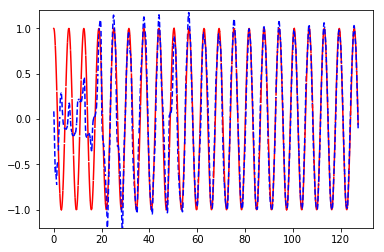

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


BATCH_START = 0
TIME_STEPS = 20
BATCH_SIZE = 50
INPUT_SIZE = 1
OUTPUT_SIZE = 1
CELL_SIZE = 10
LR = 0.006


def get_batch():
    global BATCH_START, TIME_STEPS
    # xs shape (50batch, 20steps)
    xs = np.arange(BATCH_START, BATCH_START+TIME_STEPS*BATCH_SIZE).reshape((BATCH_SIZE, TIME_STEPS)) / (10*np.pi)
    seq = np.sin(xs)
    res = np.cos(xs)
    BATCH_START += TIME_STEPS
    # plt.plot(xs[0, :], res[0, :], 'r', xs[0, :], seq[0, :], 'b--')
    # plt.show()
    # returned seq, res and xs: shape (batch, step, input)
    return [seq[:, :, np.newaxis], res[:, :, np.newaxis], xs]


class LSTMRNN(object):
    def __init__(self, n_steps, input_size, output_size, cell_size, batch_size):
        self.n_steps = n_steps
        self.input_size = input_size
        self.output_size = output_size
        self.cell_size = cell_size
        self.batch_size = batch_size
        with tf.name_scope('inputs'):
            self.xs = tf.placeholder(tf.float32, [None, n_steps, input_size], name='xs')
            self.ys = tf.placeholder(tf.float32, [None, n_steps, output_size], name='ys')
        with tf.variable_scope('in_hidden'):
            self.add_input_layer()
        with tf.variable_scope('LSTM_cell'):
            self.add_cell()
        with tf.variable_scope('out_hidden'):
            self.add_output_layer()
        with tf.name_scope('cost'):
            self.compute_cost()
        with tf.name_scope('train'):
            self.train_op = tf.train.AdamOptimizer(LR).minimize(self.cost)

    def add_input_layer(self,):
        l_in_x = tf.reshape(self.xs, [-1, self.input_size], name='2_2D')  # (batch*n_step, in_size)
        # Ws (in_size, cell_size)
        Ws_in = self._weight_variable([self.input_size, self.cell_size])
        # bs (cell_size, )
        bs_in = self._bias_variable([self.cell_size,])
        # l_in_y = (batch * n_steps, cell_size)
        with tf.name_scope('Wx_plus_b'):
            l_in_y = tf.matmul(l_in_x, Ws_in) + bs_in
        # reshape l_in_y ==> (batch, n_steps, cell_size)
        self.l_in_y = tf.reshape(l_in_y, [-1, self.n_steps, self.cell_size], name='2_3D')

    def add_cell(self):
        lstm_cell = tf.contrib.rnn.BasicLSTMCell(self.cell_size, forget_bias=1.0, state_is_tuple=True)
        with tf.name_scope('initial_state'):
            self.cell_init_state = lstm_cell.zero_state(self.batch_size, dtype=tf.float32)
        self.cell_outputs, self.cell_final_state = tf.nn.dynamic_rnn(
            lstm_cell, self.l_in_y, initial_state=self.cell_init_state, time_major=False)

    def add_output_layer(self):
        # shape = (batch * steps, cell_size)
        l_out_x = tf.reshape(self.cell_outputs, [-1, self.cell_size], name='2_2D')
        Ws_out = self._weight_variable([self.cell_size, self.output_size])
        bs_out = self._bias_variable([self.output_size, ])
        # shape = (batch * steps, output_size)
        with tf.name_scope('Wx_plus_b'):
            self.pred = tf.matmul(l_out_x, Ws_out) + bs_out

    def compute_cost(self):
        losses = tf.contrib.legacy_seq2seq.sequence_loss_by_example(
            [tf.reshape(self.pred, [-1], name='reshape_pred')],
            [tf.reshape(self.ys, [-1], name='reshape_target')],
            [tf.ones([self.batch_size * self.n_steps], dtype=tf.float32)],
            average_across_timesteps=True,
            softmax_loss_function=self.ms_error,
            name='losses'
        )
        with tf.name_scope('average_cost'):
            self.cost = tf.div(
                tf.reduce_sum(losses, name='losses_sum'),
                self.batch_size,
                name='average_cost')
            tf.summary.scalar('cost', self.cost)

    @staticmethod
    def ms_error(labels, logits):
        return tf.square(tf.subtract(labels, logits))

    def _weight_variable(self, shape, name='weights'):
        initializer = tf.random_normal_initializer(mean=0., stddev=1.,)
        return tf.get_variable(shape=shape, initializer=initializer, name=name)

    def _bias_variable(self, shape, name='biases'):
        initializer = tf.constant_initializer(0.1)
        return tf.get_variable(name=name, shape=shape, initializer=initializer)


if __name__ == '__main__':
    model = LSTMRNN(TIME_STEPS, INPUT_SIZE, OUTPUT_SIZE, CELL_SIZE, BATCH_SIZE)
    sess = tf.Session()
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("logs", sess.graph)
    # tf.initialize_all_variables() no long valid from
    # 2017-03-02 if using tensorflow >= 0.12
    if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
        init = tf.initialize_all_variables()
    else:
        init = tf.global_variables_initializer()
    sess.run(init)
    # relocate to the local dir and run this line to view it on Chrome (http://0.0.0.0:6006/):
    # $ tensorboard --logdir='logs'

    plt.ion()
    plt.show()
    for i in range(200):
        seq, res, xs = get_batch()
        if i == 0:
            feed_dict = {
                    model.xs: seq,
                    model.ys: res,
                    # create initial state
            }
        else:
            feed_dict = {
                model.xs: seq,
                model.ys: res,
                model.cell_init_state: state    # use last state as the initial state for this run
            }

        _, cost, state, pred = sess.run(
            [model.train_op, model.cost, model.cell_final_state, model.pred],
            feed_dict=feed_dict)

        # plotting
        plt.plot(xs[0, :], res[0].flatten(), 'r', xs[0, :], pred.flatten()[:TIME_STEPS], 'b--')
        plt.ylim((-1.2, 1.2))
        plt.draw()
        plt.pause(0.3)

        if i % 20 == 0:
            print('cost: ', round(cost, 4))
            result = sess.run(merged, feed_dict)
            writer.add_summary(result, i)